Nama : Salsabila Aulia Putri<br>
NIM : 211351160<br>
Kelas : Malam A

# import Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"salsabilaauliaputri","key":"65a4405ef4e6dea3eb3b0c32712764fa"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d sulmansarwar/transactions-from-a-bakery

  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 78.1MB/s]


In [5]:
!mkdir transactions-from-a-bakery
!unzip transactions-from-a-bakery.zip -d transactions-from-a-bakery
!ls transactions-from-a-bakery

Archive:  transactions-from-a-bakery.zip
  inflating: transactions-from-a-bakery/BreadBasket_DMS.csv  
BreadBasket_DMS.csv


# import library yang digunakan

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import association_rules, apriori
import networkx as nx
import warnings
warnings.filterwarnings('ignore')


In [7]:
data = pd.read_csv("transactions-from-a-bakery/BreadBasket_DMS.csv")
print("DataFrame shape :",data.shape)
data.head()

DataFrame shape : (21293, 4)


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


# Data Discovery

In [8]:
# format data waktu

data['Date'] = pd.to_datetime(data['Date'], format= "%Y-%m-%d")

In [9]:
data["Date"].dtype

dtype('<M8[ns]')

In [10]:
data["month"] = data['Date'].dt.month
data["day"] = data['Date'].dt.weekday
data.head()

,Date,Time,Transaction,Item,month,day
0,2016-10-30,09:58:11,1,Bread,10,6
1,2016-10-30,10:05:34,2,Scandinavian,10,6
2,2016-10-30,10:05:34,2,Scandinavian,10,6
3,2016-10-30,10:07:57,3,Hot chocolate,10,6
4,2016-10-30,10:07:57,3,Jam,10,6


0 - 6 = Monday - Sunday (Senin - Minggu)

# EDA (minimal 5)

Text(0.5, 1.0, 'jumlah transaksi tiap bulan oktober - april, size = 16')

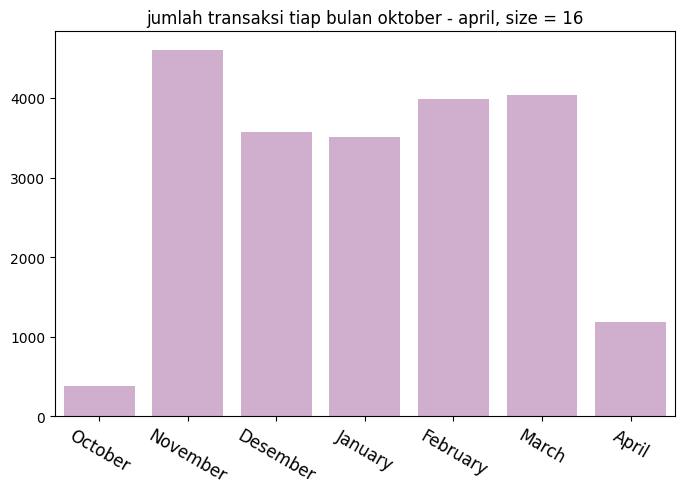

In [11]:
# transaksi tiap bulan

data_perbulan = data.groupby('month')['Transaction'].count()
data_perbulan = pd.concat([data_perbulan.iloc[4:], data_perbulan.iloc[:4]])

plt.figure(figsize= (8,5))
sns.barplot(
    x = ["October", "November", "Desember", "January", "February", "March", "April"],
    y = data_perbulan.values, color="#D5AAD3")
plt.xticks(size = 12, rotation = -30)
plt.title("jumlah transaksi tiap bulan oktober - april, size = 16")

In [12]:
freq = (data['Item'].value_counts())
freq.head()

Coffee    5471
Bread     3325
Tea       1435
Cake      1025
Pastry     856
Name: Item, dtype: int64

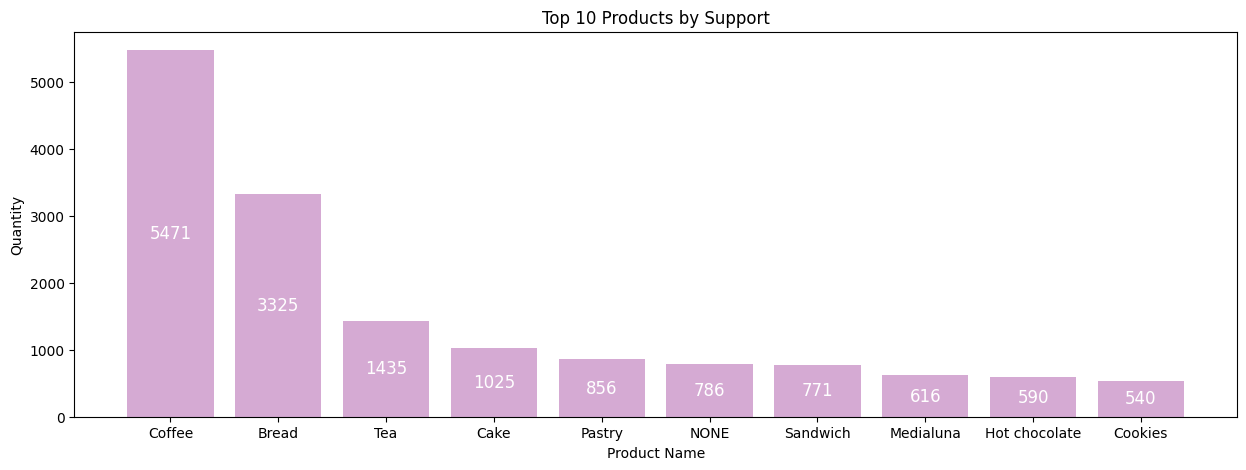

In [13]:
plt.figure(figsize = (15,5))
bars = plt.bar(x = np.arange(len(freq.head(10))), height = (freq).head(10),color='#D5AAD3')
plt.bar_label(bars, fontsize=12, color='white', label_type = 'center')
plt.xticks(ticks = np.arange(len(freq.head(10))), labels = freq.index[:10])

plt.title('Top 10 Products by Support')
plt.ylabel('Quantity')
plt.xlabel('Product Name')
plt.show()

In [14]:
member_shopping_frequency = data.groupby('Transaction')['Item'].count().sort_values(ascending=False)
print(member_shopping_frequency)

Transaction
6474    12
6279    11
6716    11
6412    11
6045    10
        ..
4586     1
4585     1
4584     1
4582     1
9684     1
Name: Item, Length: 9531, dtype: int64


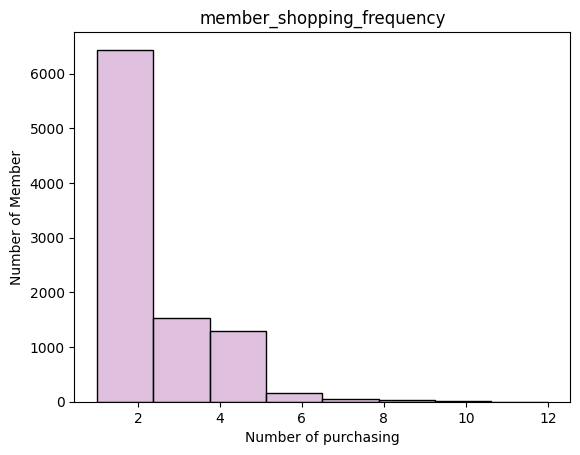

In [15]:
sns.histplot(member_shopping_frequency, bins=8, kde=False,color='#D5AAD3')
plt.xlabel('Number of purchasing')
plt.ylabel('Number of Member')
plt.title('member_shopping_frequency')
plt.show()

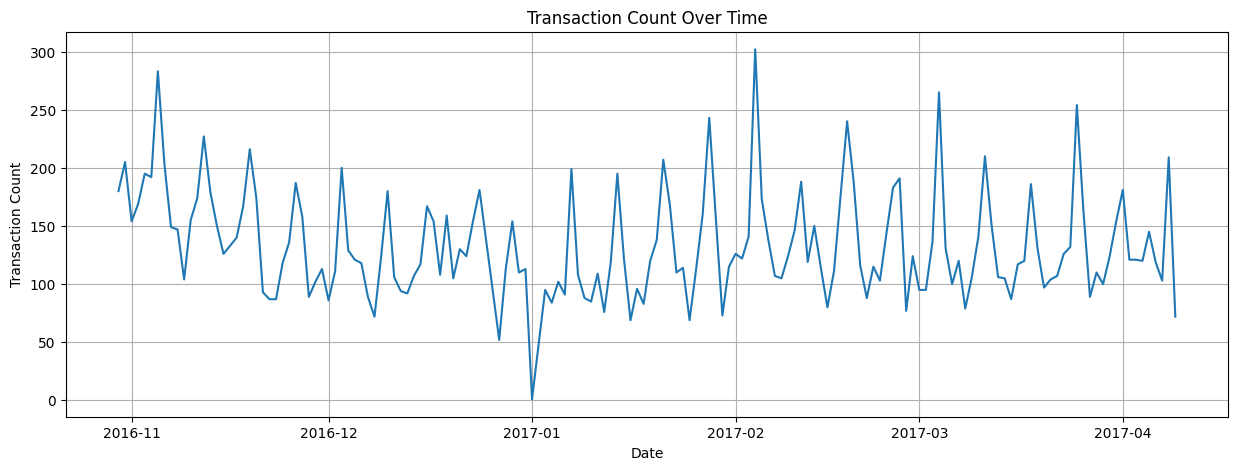

In [16]:
# Group by 'Date' and count the number of transactions
transactions_by_date = data.groupby('Date')['Transaction'].count()

# Plotting the line chart
plt.figure(figsize=(15, 5))
plt.plot(transactions_by_date.index, transactions_by_date.values, linestyle='-')

plt.title('Transaction Count Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.grid(True)
plt.show()

In [17]:
data.head()

,Date,Time,Transaction,Item,month,day
0,2016-10-30,09:58:11,1,Bread,10,6
1,2016-10-30,10:05:34,2,Scandinavian,10,6
2,2016-10-30,10:05:34,2,Scandinavian,10,6
3,2016-10-30,10:07:57,3,Hot chocolate,10,6
4,2016-10-30,10:07:57,3,Jam,10,6


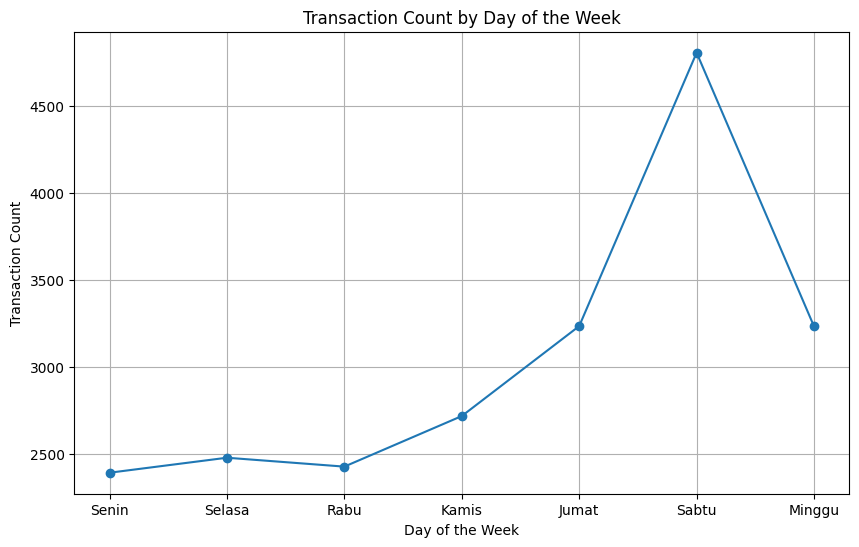

In [18]:
transactions_by_day = data.groupby('day')['Transaction'].count()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(transactions_by_day.index, transactions_by_day.values, marker='o', linestyle='-')

# Labeling the chart
plt.title('Transaction Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')
plt.xticks(range(7), ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])

plt.grid(True)
plt.show()

# Preprocessing

In [19]:
## data preparation

In [20]:
data["Item"] = data["Item"].apply(lambda item: item.lower())

In [21]:
data["Item"] = data["Item"].apply(lambda item: item.strip())

In [22]:
data = data[["Transaction", "Item"]].copy()
data.head()

,Transaction,Item
0,1,bread
1,2,scandinavian
2,2,scandinavian
3,3,hot chocolate
4,3,jam


In [23]:
from mlxtend.frequent_patterns import association_rules, apriori

# modeling

In [24]:
item_count = data.groupby(["Transaction", "Item"])["Item"].count().reset_index(name="Count")
item_count.head(10)

,Transaction,Item,Count
0,1,bread,1
1,2,scandinavian,2
2,3,cookies,1
3,3,hot chocolate,1
4,3,jam,1
5,4,muffin,1
6,5,bread,1
7,5,coffee,1
8,5,pastry,1
9,6,medialuna,1


In [25]:
item_count_pivot = item_count.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
print("ukuran Dataset :", item_count_pivot.shape)
item_count_pivot.head()

ukuran Dataset : (9531, 95)


Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
item_count_pivot = item_count_pivot.astype("int32")
item_count_pivot.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
def encode(x):
  if x <=0:
    return 0
  elif x >=1:
    return 1

item_count_pivot = item_count_pivot.applymap(encode)
item_count_pivot.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
print("Ukuran dataset : ", item_count_pivot.shape)
print("Jumlah Transaksi : ", item_count_pivot.shape[0])
print("Jumlah items :", item_count_pivot.shape[1])

Ukuran dataset :  (9531, 95)
Jumlah Transaksi :  9531
Jumlah items : 95


In [29]:
support = 0.01
frequent_items = apriori(item_count_pivot, min_support= support, use_colnames=True)
frequent_items.sort_values("support", ascending=False).head(10)

,support,itemsets
6,0.475081,(coffee)
2,0.324940,(bread)
27,0.141643,(tea)
4,0.103137,(cake)
35,0.089393,"(coffee, bread)"
20,0.085510,(pastry)
19,0.079005,(none)
22,0.071346,(sandwich)
16,0.061379,(medialuna)
12,0.057916,(hot chocolate)


In [30]:
metric = "lift"
min_threshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_threshold)[["antecedents","consequents","support","confidence","lift"]]
rules.sort_values('confidence', ascending=False, inplace=True)
rules.head(15)

,antecedents,consequents,support,confidence,lift
32,(toast),(coffee),0.023502,0.704403,1.482699
31,(spanish brunch),(coffee),0.010807,0.598837,1.260494
19,(medialuna),(coffee),0.034939,0.569231,1.198175
25,(pastry),(coffee),0.047214,0.552147,1.162216
1,(alfajores),(coffee),0.019515,0.540698,1.138116
17,(juice),(coffee),0.020460,0.534247,1.124537
23,(none),(coffee),0.042073,0.532537,1.120938
27,(sandwich),(coffee),0.037981,0.532353,1.120551
7,(cake),(coffee),0.054349,0.526958,1.109196
29,(scone),(coffee),0.017941,0.522936,1.100729


# Visualisasi hasil algoritma

<Axes: xlabel='confidence', ylabel='lift'>

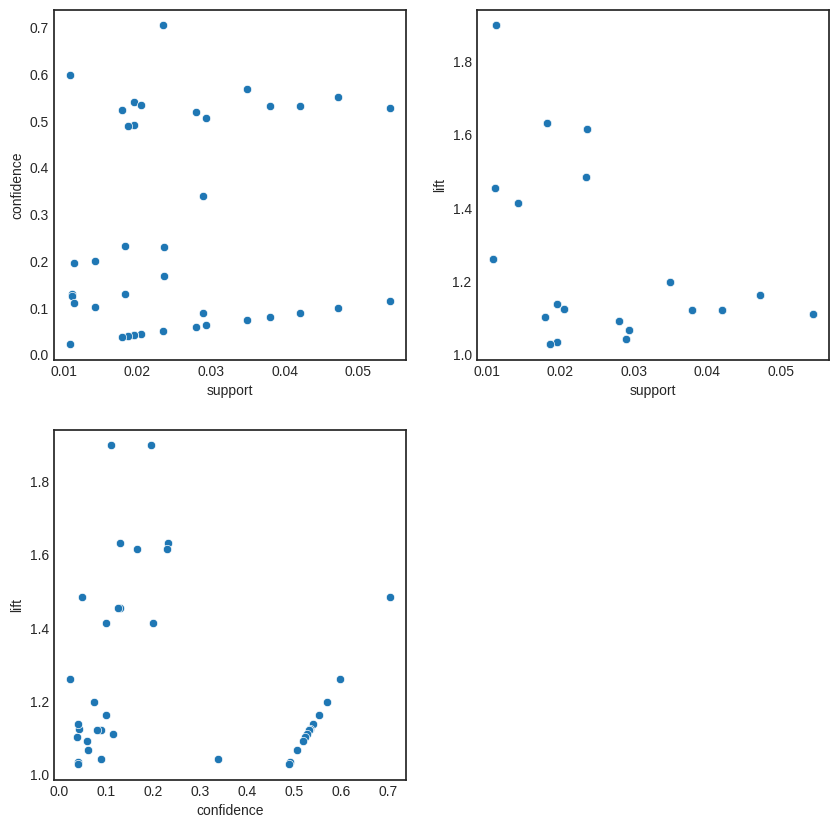

In [31]:
plt.figure(figsize = (10, 10))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules)

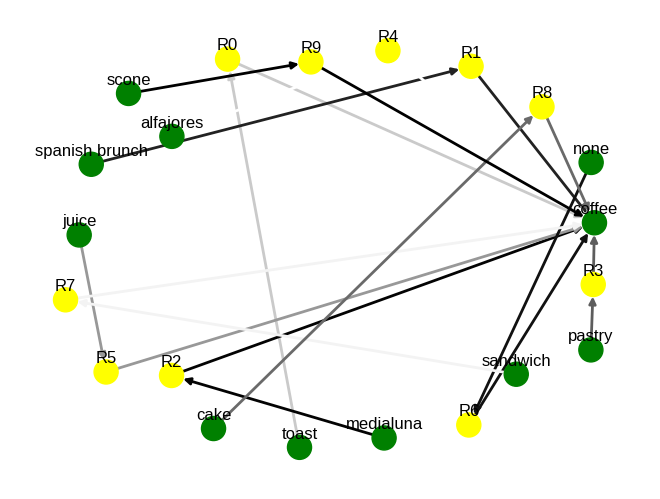

In [32]:
def draw_graph(rules, rules_to_show):
  import networkx as nx
  G1 = nx.DiGraph()

  color_map=[]
  N = 50
  colors = np.random.rand(N)
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']


  for i in range (rules_to_show):
    G1.add_nodes_from(["R"+str(i)])


    for a in rules.iloc[i]['antecedents']:

        G1.add_nodes_from([a])

        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)

    for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([a])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

  for node in G1:
       found_a_string = False
       for item in strs:
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')

  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)

  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

#Calling function with 10 rules
draw_graph(rules, 10)

# save model (pickle)